In [1]:
import os
import time
import uuid
import cv2

import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model

### 1.1. Lấy ảnh từ Webcame

In [37]:
IMAGES_PATH = os.path.join('data','images')
number_images = 50

In [38]:
# lấy ảnh từ video
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.2. Gán nhãn dữ liệu với Labelme

In [39]:
!labelme

# 2.sd

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [105]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [106]:
images = tf.data.Dataset.list_files('data/images/*.jpg')
images.as_numpy_iterator().next()

b'data\\images\\31abd16f-ce1a-11ed-a765-706655b34db8.jpg'

In [30]:
def load_img(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [108]:
images = images.map(load_img)
images.as_numpy_iterator().next()
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

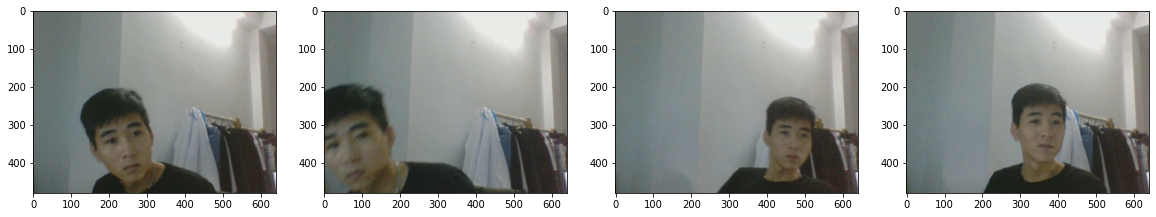

In [110]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [111]:
35*0.7 # 26 train
35*0.3 # 5 test/ 5 val

10.5

In [112]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

In [16]:
import albumentations as alb
"""- Thư viện cung cấp các phương pháp mở rộng (augmentation)
hình ảnh tiên tiến để tăng cường tập dữ liệu huấn luyện
và cải thiện khả năng tổng quát hóa của mô hình."""

'- Thư viện cung cấp các phương pháp mở rộng (augmentation)\nhình ảnh tiên tiến để tăng cường tập dữ liệu huấn luyện\nvà cải thiện khả năng tổng quát hóa của mô hình.'

In [17]:
augmentor = alb.Compose([
        alb.RandomCrop(width=450, height=450), #cắt ngẫu nhiên một vùng ảnh có kích thước 450x450 pixels.
        alb.HorizontalFlip(p=0.5), # lật ngang ảnh với xác suất 0.5.
        alb.RandomBrightnessContrast(p=0.2), # tăng giảm độ sáng và độ tương phản của ảnh với xác suất 0.2.
        alb.RandomGamma(p=0.2), # tăng giảm độ gamma của ảnh với xác suất 0.2.
        alb.RGBShift(p=0.2), # thay đổi ngẫu nhiên giá trị màu sắc của ảnh với xác suất 0.2.
        alb.VerticalFlip(p=0.5)], #lật dọc ảnh với xác suất 0.5.
        bbox_params=alb.BboxParams(format='albumentations',
                        label_fields=['class_labels']))

In [22]:
img = cv2.imread(os.path.join('data','train', 'images','2ae8c4f2-ce1a-11ed-a968-706655b34db8.jpg'))
with open(os.path.join('data', 'train', 'labels', '2ae8c4f2-ce1a-11ed-a968-706655b34db8.json'), 'r') as f:
    label = json.load(f)
label['shapes'][0]['points']

[[261.044776119403, 260.39800995024876],
 [395.87064676616916, 391.7412935323383]]

### Trích xuất tọa độ và thay đổi tỷ lệ để phù hợp với độ phân giải hình ảnh

In [23]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords

[261.044776119403, 260.39800995024876, 395.87064676616916, 391.7412935323383]

In [24]:
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.40788246268656725,
 0.5424958540630183,
 0.6185478855721394,
 0.8161276948590381]

### Áp dụng Augmentations và Xem kết quả

In [25]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
augmented['bboxes'][0][2:]
augmented['bboxes']

[(0.18695411829740172,
  0.5342177998894417,
  0.4865671641791044,
  0.8260917634051963)]

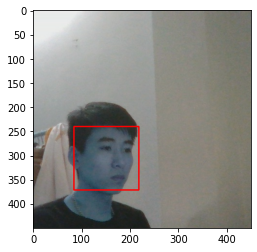

In [26]:
cv2.rectangle(augmented['image'],
                tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
                tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
                (255,0,0), 2)

plt.imshow(augmented['image'])

### Xây dựng và chạy quy trình Augmentation

In [27]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.24541355721393038, 0.4917081260364842, 0.004430970149253777, 0.9798922056384742, 'face'].
x_max is less than or equal to x_min for bbox [0.5400342039800995, 0.9259950248756219, 0.20032649253731344, 0.45646766169154224, 'face'].
x_max is less than or equal to x_min for bbox [0.6799595771144278, 0.8399668325041459, 0.43586753731343286, 0.3922056384742952, 'face'].


### Load ảnh Augmented vào Tensorflow Dataset

In [31]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_img)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [32]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_img)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [33]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_img)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)
train_images.as_numpy_iterator().next()

array([[[0.0646446 , 0.06366421, 0.18376225],
        [0.06372549, 0.07910539, 0.19344363],
        [0.04234068, 0.06158088, 0.17941177],
        ...,
        [0.27996323, 0.33878675, 0.49172795],
        [0.26942402, 0.3319853 , 0.47371325],
        [0.26488972, 0.3251838 , 0.4560662 ]],

       [[0.04528186, 0.04920343, 0.16685049],
        [0.05159314, 0.04754902, 0.16911764],
        [0.0646446 , 0.06758578, 0.1896446 ],
        ...,
        [0.25275734, 0.3233456 , 0.48020834],
        [0.22389705, 0.2944853 , 0.44362745],
        [0.2689951 , 0.32683823, 0.4704657 ]],

       [[0.04264706, 0.05147059, 0.17303921],
        [0.05067402, 0.04656863, 0.1721201 ],
        [0.06617647, 0.0622549 , 0.1877451 ],
        ...,
        [0.2665441 , 0.33713236, 0.4939951 ],
        [0.26096815, 0.33155638, 0.4815564 ],
        [0.26556373, 0.32193628, 0.4699755 ]],

       ...,

       [[0.83137256, 0.8392157 , 0.9882353 ],
        [0.83137256, 0.8392157 , 0.9882353 ],
        [0.83137256, 0

### Load label vào Tensorflow Dataset

In [34]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [35]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [37]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [36]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2703, 0.1472, 0.5854, 0.4602], dtype=float16))

### Kết hợp các mẫu nhãn và hình ảnh

#### Kiểu tra kích thước dữ liệu

In [38]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(1440, 1440, 240, 240, 300, 300)

#### Tạo bộ dữ liệu cuối cùng (Hình ảnh/Nhãn)

In [39]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(2000)
train = train.batch(8)
train = train.prefetch(4)

In [40]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(400)
test = test.batch(8)
test = test.prefetch(4)

In [41]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(500)
val = val.batch(8)
val = val.prefetch(4)
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.1464, 0.1274, 0.4592, 0.513 ],
        [0.    , 0.4514, 0.1917, 0.8306],
        [0.526 , 0.4248, 0.9507, 0.804 ],
        [0.4683, 0.1163, 0.822 , 0.5596],
        [0.5483, 0.541 , 0.8555, 0.8457],
        [0.4043, 0.1364, 0.7017, 0.469 ],
        [0.3293, 0.1306, 0.6167, 0.449 ],
        [0.3396, 0.1251, 0.6523, 0.511 ]], dtype=float16))

#### Xem hình ảnh và nhãn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


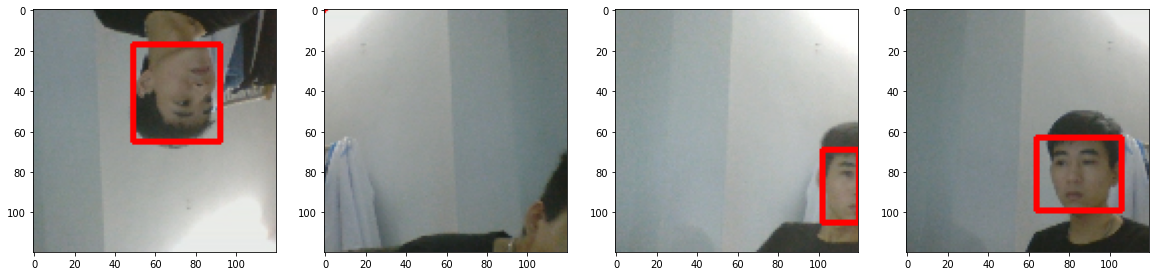

In [136]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                    tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                    tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Xây dựng mô hình Deep Learning

In [42]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

Conv_vgg16 = VGG16(include_top= False)
Conv_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [43]:
def build_model():
    input_layer = Input(shape=(120,120,3))
    vgg = VGG16(include_top=False)(input_layer)

    # Mô hình phân loại
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Mô hình lấy box
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [44]:
facetracker = build_model()
facetracker.summary()
X, y = train.as_numpy_iterator().next()
X.shape
classes, coords = facetracker.predict(X)
classes, coords

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_3[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

(array([[0.49198425],
        [0.5245405 ],
        [0.5108117 ],
        [0.56914026],
        [0.49190503],
        [0.57450116],
        [0.50595367],
        [0.56408805]], dtype=float32),
 array([[0.55067617, 0.40589583, 0.27766782, 0.36132348],
        [0.58438283, 0.44861156, 0.36059877, 0.33763593],
        [0.5702123 , 0.40661612, 0.36481002, 0.36922753],
        [0.50918436, 0.37271658, 0.34252077, 0.3323817 ],
        [0.58680916, 0.46566373, 0.34559062, 0.36182597],
        [0.534401  , 0.39978597, 0.35608563, 0.36066613],
        [0.62506884, 0.4348448 , 0.33823657, 0.32570454],
        [0.5581297 , 0.38820317, 0.3321556 , 0.37310022]], dtype=float32))

### Thiết lập tối ưu (Optimizers)

In [45]:
# decay: kỹ thuật sử dụng để giảm dần learning rate theo thời gian
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch
print(lr_decay)
opt = tf.keras.optimizers.Adam(learning_rate= 0.0001, decay= lr_decay)

0.0018518518518518515


### Thiết lập Loss vị trí box và phân loại

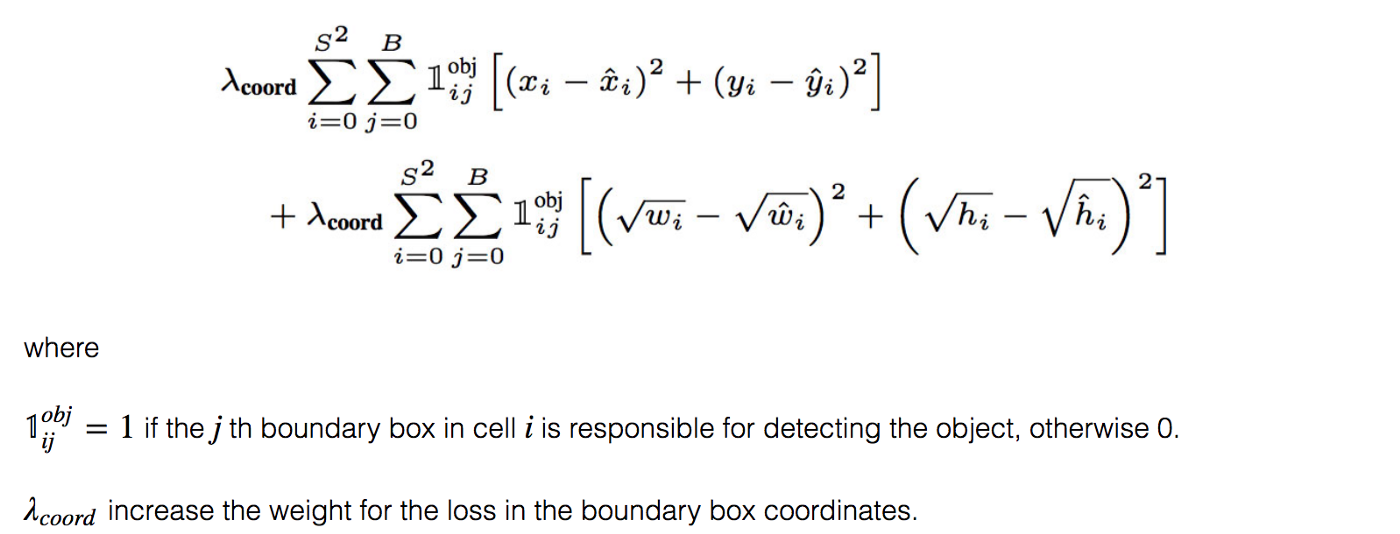

In [46]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    return delta_coord + delta_size

In [47]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [48]:
localization_loss(y[1], coords)
print(classloss(y[0], classes))
print(regressloss(y[1], coords))

tf.Tensor(0.63442934, shape=(), dtype=float32)
tf.Tensor(4.969391, shape=(), dtype=float32)


# Huấn luyện mô hình

In [49]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            total_loss = batch_localizationloss+0.5*batch_classloss
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch
        classes, coords = self.model(X, training=False)
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [50]:
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)

In [52]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs= 50, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/50
180/180 [==============================] - 16s 78ms/step - total_loss: 0.0266 - class_loss: 7.1090e-04 - regress_loss: 0.0262 - val_total_loss: 0.0486 - val_class_loss: 1.3761e-04 - val_regress_loss: 0.0485
Epoch 2/50
180/180 [==============================] - 13s 66ms/step - total_loss: 0.0107 - class_loss: 1.4048e-04 - regress_loss: 0.0106 - val_total_loss: 0.0151 - val_class_loss: 5.8327e-05 - val_regress_loss: 0.0151
Epoch 3/50
180/180 [==============================] - 13s 66ms/step - total_loss: 0.0078 - class_loss: 6.9910e-05 - regress_loss: 0.0077 - val_total_loss: 0.0102 - val_class_loss: 2.9147e-05 - val_regress_loss: 0.0102
Epoch 4/50
180/180 [==============================] - 13s 67ms/step - total_loss: 0.0043 - class_loss: 3.8906e-05 - regress_loss: 0.0043 - val_total_loss: 0.0109 - val_class_loss: 4.0233e-06 - val_regress_loss: 0.0109
Epoch 5/50
180/180 [==============================] - 13s 67ms/step - total_loss: 0.0030 - class_loss: 2.9948e-05 - regress_loss

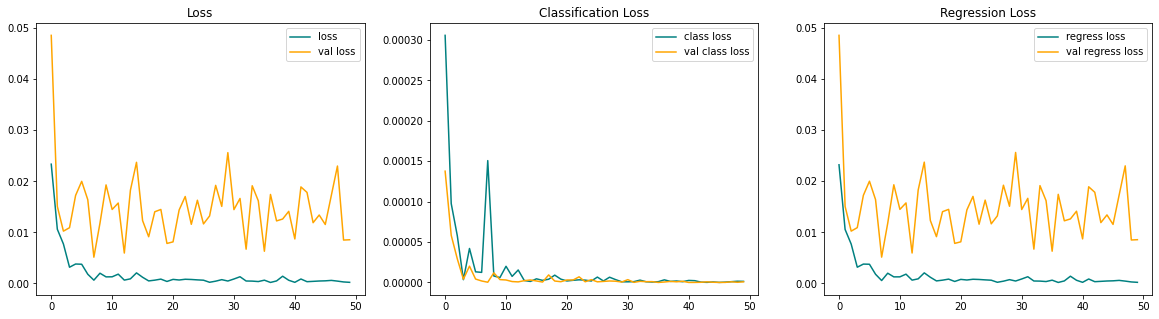

In [56]:
hist.history
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


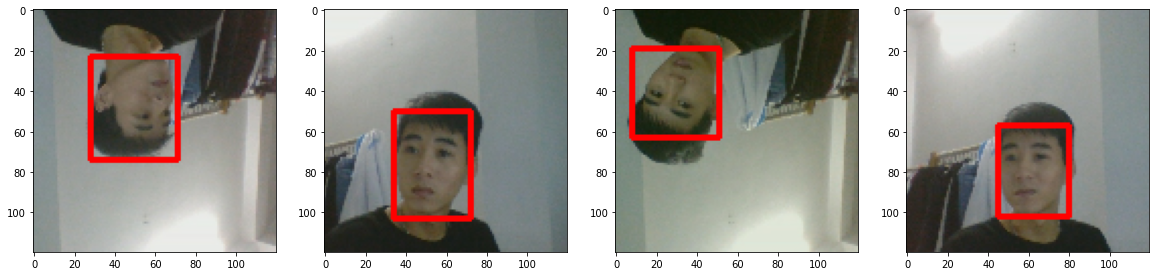

In [57]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                        tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                        tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [59]:
facetracker.save('facetracker.h5')

# Phát hiện với thời gian thực

In [2]:
facetracker = load_model('facetracker.h5')
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                        tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                        tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                        tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [0,-30])),
                        tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])),
                            (255,0,0), -1)
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                                [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [4]:
facetracker = load_model('facetracker_.h5')
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                        tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                        tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                        tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [0,-30])),
                        tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])),
                            (255,0,0), -1)
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                                [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()